In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df=pd.read_csv('/home/andre301267/git/BD/temp/imp_fert_ncm_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])

In [2]:
comex_df.insert(0,'date',pd.to_datetime(comex_df.CO_ANO.astype(str)+'/'+comex_df.CO_MES.astype(str)+'/1'))

In [3]:
data_ini=comex_df.date.min()

In [4]:
data_fim=comex_df.date.max()

# 1a Fase: Seleciona a planilha de interesse

In [5]:
comex_df.nick.unique()

array(['MOP', 'MOP<60', 'NK', 'NPK', 'Nit.Sódio Potássico 15 15',
       'Outros N', 'Outros nitratos de sódio', 'SAM', 'SOP<52', 'MAP',
       'NAM', 'Nit.Sódio natural<16,3', 'Outros Nit.Sódio potássico',
       'Outros potássicos', 'Superfosfatos<22', 'UREIA',
       'DAP arsênio> 6 mg/kg', 'NCa', 'Outros SOP', 'PK',
       'Superfosfato>45', 'Ureia, mesmo aquosa',
       'Outros Nit.Sódio, naturais', 'NP', 'Nitratos e fosfatos',
       'Superfosfatos>35', 'Outros superfosfatos'], dtype=object)

In [6]:
nick=['MOP']
UF=['BA']
CO_PAIS=[]
CO_URF=[]

l=['nick','UF','CO_PAIS','CO_URF']
d={'nick':nick,'UF':UF,'CO_PAIS':CO_PAIS,'CO_URF':CO_URF}
for x in l:
    if len(d[x])>0:
        comex_df=comex_df[comex_df[x].isin(d[x])]
    else:
        comex_df.drop(columns=x,inplace=True)

In [7]:
km=2

In [8]:
comex_df=comex_df[comex_df.km==km]
comex_df.drop(columns='km',inplace=True)

# 2a Fase: Sparse Matrix - train

In [9]:
col_ord=['CO_ANO','CO_MES']
col_cat=[x for x in l if x in comex_df.columns.tolist()]
col_quanti=['KG_LIQUIDO','VL_FOB','VL_FRETE']
comex_df=comex_df[col_ord+col_cat+col_quanti].sort_values(by=col_ord)
comex_df[col_ord+col_cat]=comex_df[col_ord+col_cat].astype('category')
comex_df_g=comex_df.groupby(by=col_ord+col_cat,observed=False)[col_quanti].sum().reset_index()
comex_df_g.insert(0,'date',pd.to_datetime(comex_df_g.CO_ANO.astype(str)+'/'+comex_df_g.CO_MES.astype(str)+'/1'))
comex_df_g=comex_df_g[(comex_df_g.date>=data_ini)&(comex_df_g.date<=data_fim)].sort_values('date')
train=comex_df_g

# 3a Fase: train & test

In [10]:
train_end=train.date.max()-DateOffset(years=1)
test=train[train.date>train_end]
train=train[train.date<=train_end]

# 4a Fase: Dummies

In [11]:
comex_df_o=pd.concat([train,test])
comex_df_o.CO_MES=comex_df_o.CO_MES.astype('category')
comex_df_o.drop(columns='CO_ANO',inplace=True)
comex_df_o.date=comex_df_o.date.astype(int)
comex_df_dumm=pd.get_dummies(comex_df_o, prefix_sep='~')

# 4a fase: Classificação

In [12]:
comex_df_dumm=comex_df_dumm.assign(oc=1)
comex_df_dumm.loc[comex_df_dumm.KG_LIQUIDO==0,'oc']=0
comex_df_dumm.select_dtypes(exclude='bool')
train=comex_df_dumm[comex_df_dumm.date.astype('datetime64[ns]')<=train_end]
test=comex_df_dumm[comex_df_dumm.date.astype('datetime64[ns]')>train_end]
X_train=train[['date']+train.select_dtypes('bool').columns.tolist()]
y_train=train['oc']
X_test=test[['date']+test.select_dtypes('bool').columns.tolist()]

In [13]:
from sklearn.ensemble import RandomForestClassifier as RFC
RFC=RFC()
RFC.fit(X_train,y_train)
test_pred=pd.concat([X_test.reset_index(drop=True),pd.DataFrame({'oc_pred':RFC.predict(X_test)})],axis=1)

In [14]:
test_pred=test_pred.merge(test.drop(columns=col_quanti))

# 5a fase: Regression

In [15]:
train=train[train.oc==1]

In [16]:
test_pred=test.merge(test_pred)

In [17]:
test_pred_r=test_pred[(test_pred.oc==1)&(test_pred.oc_pred==1)]

In [18]:
X_train=pd.concat([train[['date']],train.select_dtypes('bool')],axis=1)

In [19]:
y_train=train[col_quanti]

In [20]:
X_test=pd.concat([test_pred_r[['date']],test_pred_r.select_dtypes('bool')],axis=1)

In [21]:
from sklearn.ensemble import RandomForestRegressor as REG
REG=REG(max_features=1, max_depth=1)

In [ ]:
from sklearn.linear_model import LinearRegression as LM
LM=LM()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
polynomial_features = PolynomialFeatures(degree=1)
REG = make_pipeline(polynomial_features, LM)

In [22]:
REG.fit(X_train,y_train)
X_test=pd.concat([X_test,pd.DataFrame(REG.predict(X_test),columns=col_quanti)],axis=1)

In [23]:
for w in col_quanti:
    X_test=X_test.rename(columns={w:w+'_pred'})

In [24]:
test_pred=test_pred.merge(X_test)

# 6a fase: Score

In [25]:
b=test_pred.select_dtypes('bool')
o=test_pred.select_dtypes(exclude='bool')

m=pd.from_dummies(b.loc[:,b.columns.str.contains('CO_MES')],sep='~')
n=pd.from_dummies(b.loc[:,b.columns.str.contains('nick')],sep='~')
u=pd.from_dummies(b.loc[:,b.columns.str.contains('UF')],sep='~')
results=pd.concat([o,m,n,u],axis=1)
results.date=results.date.astype('datetime64[ns]')

date_results=results[['date']].drop_duplicates().assign(dist_prev=np.arange(1,len(results.date.unique())+1))

results=date_results.merge(results)

In [26]:
from sklearn import metrics
for w in col_quanti:
    print('mean_absolute_percentage_error - ',w,':',round(metrics.mean_absolute_percentage_error(results[w],results[w+'_pred']),1))

mean_absolute_percentage_error -  KG_LIQUIDO : 0.5
mean_absolute_percentage_error -  VL_FOB : 0.4
mean_absolute_percentage_error -  VL_FRETE : 0.5


In [27]:
rl=pd.concat([
    results[['date','KG_LIQUIDO']].assign(tipo='real'),
    results[['date','KG_LIQUIDO_pred']].assign(tipo='pred').rename(columns={'KG_LIQUIDO_pred':'KG_LIQUIDO'})
])

# Graph

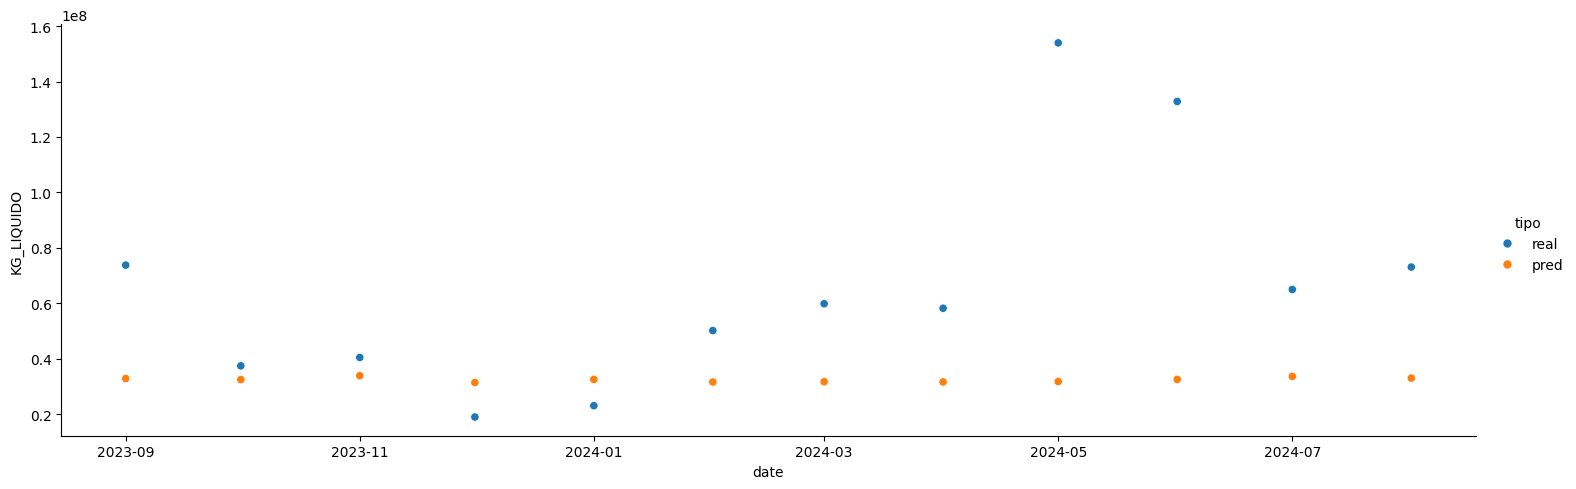

In [28]:
sns.relplot(data=rl,x='date',y='KG_LIQUIDO',hue='tipo',aspect=3)

# Lixo